In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from sklearn import *
import math 

In [6]:
# data
d=5
L=2000


eta_X=datasets.make_spd_matrix(d, random_state=None)
eta_N=datasets.make_spd_matrix(d, random_state=None)   
eta_Y=eta_X+eta_N

meu=np.zeros(d)
def func(x):
    return x

def gen_X():
    return np.random.multivariate_normal( mean=meu,
                                  cov=eta_X,
                                  size = L)
def noise():
    return np.random.multivariate_normal( mean=meu,
                                  cov=eta_N,
                                 size = L)

def gen_Y(X,N):
    return func(X)+func(N)



In [7]:
X=gen_X()
N=noise()
y=gen_Y(X,N)
mi = 0.5*math.log(np.linalg.det(eta_Y)/np.linalg.det(eta_X),2)
print(mi)

3.402688689292958


In [8]:
def ma(array, policy,window_size=None, beta=None):
    x=np.zeros(len(array))
    if policy=='window':
        for i in range(0, len(array)):
            if i<window_size:
                x[i]= np.mean(array[0: i])
            else:
                x[i]= np.mean(array[i-window_size: i])
    elif policy=='weighted':
        x[0]=array[0]
        for i in range(1, len(array)):
               x[i]=x[i-1]*(1-beta)+beta*array[i]
    elif policy=='None':
        for i in range(1, len(array)):
             x[i]=array[i] 
    return x


C:\Users\ahmedadel\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


true value:9999996
3.402688689292958
calculated value:
0.38046517968177795
error
88.81868973559158




C:\Users\ahmedadel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


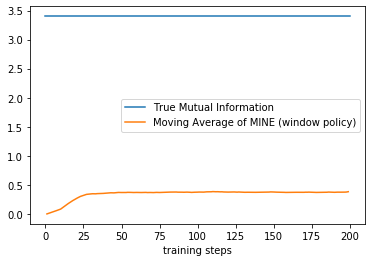

In [9]:
H=40
M=100
n_epochs = 200

def MINE(x_in, y_in):
    
    # shuffle and concatenate
    y_shuffle = tf.random_shuffle(y_in)
    x_conc = tf.concat([x_in, x_in], axis=0)
    y_conc = tf.concat([y_in, y_shuffle], axis=0)
    
    # propagate the forward pass
    layerx = tf.contrib.layers.fully_connected(x_conc, H, activation_fn=None)
    layery = tf.contrib.layers.fully_connected(y_conc, H, activation_fn=None)
    layer2 = tf.nn.relu(layerx + layery)
    layer3 = tf.contrib.layers.fully_connected(layer2, L, activation_fn=None)
    output = tf.contrib.layers.fully_connected(layer2, L, activation_fn=None)
    
    # split in T_xy and T_x_y predictions
    N_samples = tf.shape(x_in)[0]
    T_xy = output[:N_samples]
    T_x_y = output[N_samples:]
    # compute the negative loss (maximise loss == minimise -loss)
    neg_loss = -(tf.reduce_mean(T_xy, axis=0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y))))
    opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(neg_loss)

    return neg_loss, opt

# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, 1], name='x_in')
y_in = tf.placeholder(tf.float32, [None, 1], name='y_in')

# make the loss and optimisation graphs
neg_loss, opt = MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []
for epoch in range(n_epochs):
    
    # generate the data
    x_sample=gen_X()
    noise_sample=noise()
    Y=gen_Y(x_sample,noise_sample)
    X_1D=X.reshape(-1,1)
    Y_1D=y.reshape(-1,1)

    # perform the training step
    feed_dict = {x_in:X_1D, y_in:Y_1D}
    _, neg_l = sess.run([opt, neg_loss], feed_dict=feed_dict)

    # save the loss
    MIs.append(-neg_l)
    print(epoch/n_epochs*100, end='\r')
mv_av=ma(MIs, policy='window', window_size=10)



fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av)), mv_av, label='Moving Average of MINE (window policy)')

ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.savefig('MINE_window.png')
fig.show()



error=(abs(mv_av[-1]-mi)/mi)*100
print('true value:')
print(mi)
print('calculated value:')
print(mv_av[-1])
print('error')
print(error)
print('\n')


